### Initial setup

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
# ### Read data
data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
# ### Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values

### Strategy: Mean imputation

In [5]:
# ### Strategy two: imputation given by the mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#BDNF
X_bdnf = imp_mean.fit_transform(x_bdnf)
Y_bdnf = imp_mean.fit_transform(y_bdnf)

#Syn
X_syn = imp_mean.fit_transform(x_syn)

#NNF
X_nnf = imp_mean.fit_transform(x_nnf)

### Fit the model 1st Option

In [6]:
with pm.Model() as hierar_meanimput:
    #Define hyperpriors
    mu_beta_meanimput = pm.Normal('mu_beta_meanimput', mu=0, sd=0.1) 
    sd_beta_meanimput = pm.HalfNormal('sd_beta_meanimput', sd=5)
    #Define priors
    beta_bdnf_meanimput = pm.Normal('beta_bdnf_meanimput', mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(6,1))
    beta_syn_meanimput = pm.Normal('beta_syn_meanimput', mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(2,1))
    beta_nnf_meanimput = pm.Normal('beta_nnf_meanimput', mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(3,1))

In [7]:
# ## Define bndf 
with hierar_meanimput:
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf_meanimput = pm.Deterministic('lp_bdnf_meanimput', pm.math.dot(X_bdnf, beta_bdnf_meanimput)) 
    y_obs_bdnf_meanimput = pm.Bernoulli('y_obs_bdnf_meanimput', logit_p=lp_bdnf_meanimput, observed=Y_bdnf)

In [8]:
# ## Define syn
with hierar_meanimput:   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn_meanimput =  pm.Deterministic('lp_syn_meanimput', 
                                         lp_bdnf_meanimput + pm.math.dot(X_syn, beta_syn_meanimput))    
    y_obs_syn_meanimput = pm.Bernoulli("y_obs_syn_meanimput", 
                                       logit_p = lp_syn_meanimput, observed=Y_syn)

In [9]:
# ## Define nnf
with hierar_meanimput:
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf_meanimput = pm.Deterministic('lp_nnf_meanimput', 
                                        lp_syn_meanimput + pm.math.dot(X_nnf, beta_nnf_meanimput))
    y_obs_nnf_meanimput = pm.Bernoulli("y_obs_nnf_meanimput", logit_p=lp_nnf_meanimput, observed=Y_nnf)

In [10]:
# ## Define DNT
with hierar_meanimput:
    #Define causal relationships for DNT
    lp_dnt_meanimput = pm.Deterministic('lp_dnt_meanimput', 
                                        lp_bdnf_meanimput + lp_syn_meanimput + lp_nnf_meanimput)
    y_obs_dnt_meanimput = pm.Bernoulli('y_obs_dnt_meanimput', 
                                       logit_p=lp_dnt_meanimput, observed=Y_dnt)

In [11]:
#Checking the proposed structure of model
hierar_meanimput.check_test_point()

mu_beta_meanimput           1.38
sd_beta_meanimput_log__    -0.77
beta_bdnf_meanimput       -13.82
beta_syn_meanimput         -4.61
beta_nnf_meanimput         -6.91
y_obs_bdnf_meanimput      -67.24
y_obs_syn_meanimput       -67.24
y_obs_nnf_meanimput       -67.24
y_obs_dnt_meanimput       -67.24
Name: Log-probability of test_point, dtype: float64

In [12]:
#Make the inferences
with hierar_meanimput:
    trace_meanimput = pm.sample(cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_nnf_meanimput, beta_syn_meanimput, beta_bdnf_meanimput, sd_beta_meanimput, mu_beta_meanimput]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


### Fit the model 2nd Option LKJCholeskyCov and MvNormal

In [13]:
with pm.Model() as hierar_cov:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=1)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [14]:
with hierar_cov:
    #LKJ prior for covariance matrix    
    bdnf_chol, corr, stds = pm.LKJCholeskyCov(
        'bdnf_chol', n=6, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False)
    
    #transform this vector into the lower triangular matrix 
    #chol_bdnf = pm.expand_packed_triangular(6, bdnf_chol)
    #cov = pm.Deterministic("cov", chol_bdnf.dot(chol_bdnf.T))
    
    mu_bdnf = pm.Normal('mu_bdnf', mu=0, sd=1, shape=6)
    y_bdnf = pm.MvNormal('y_bdnf', mu=mu_bdnf, chol=bdnf_chol, observed=X_bdnf)
    
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf =  pm.Deterministic('lp_bdnf', tt.dot(y_bdnf, beta_bdnf))    
    y_obs_bdnf = pm.Bernoulli("y_obs_bdnf", logit_p=lp_bdnf, observed=Y_bdnf)
    

In [15]:
with hierar_cov:
    #LKJ prior for covariance matrix    
    syn_chol, corr, stds = pm.LKJCholeskyCov(
        'syn_chol', n=2, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_syn = pm.Normal('mu_syn', mu=0, sd=1, shape=2)
    y_syn = pm.MvNormal('y_syn', mu=mu_syn, chol=syn_chol, observed=X_syn)
    
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(y_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p=lp_syn, observed=Y_syn)
    

In [16]:
with hierar_cov:
    #LKJ prior for covariance matrix    
    nnf_chol, corr, stds = pm.LKJCholeskyCov(
        'nnf_chol', n=3, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_nnf = pm.Normal('mu_nnf', mu=0, sd=1, shape=3)
    y_nnf = pm.MvNormal('y_nnf', mu=mu_nnf, chol=nnf_chol, observed=X_nnf)
    
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf =  pm.Deterministic('lp_nnf', lp_syn + tt.dot(y_nnf, beta_nnf))    
    y_obs_syn = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=Y_syn)

In [17]:
with hierar_cov:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

In [18]:
#Checking the proposed structure of model
hierar_cov.check_test_point()

mu_beta                              3.69
sd_beta_log__                       -0.77
beta_bdnf                           -4.16
beta_syn                            -1.39
beta_nnf                            -2.08
bdnf_chol_cholesky-cov-packed__     -0.92
mu_bdnf                             -5.51
syn_chol_cholesky-cov-packed__      -0.76
mu_syn                              -1.84
nnf_chol_cholesky-cov-packed__      -0.58
mu_nnf                              -2.76
y_bdnf                            -680.69
y_obs_bdnf                         -67.24
y_syn                             -245.27
y_obs_syn                          -67.24
y_nnf                             -392.91
y_obs_nnf                          -67.24
y_obs_dnt                          -67.24
Name: Log-probability of test_point, dtype: float64

In [19]:
with hierar_cov:
    trace_cov = pm.sample(cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_nnf, nnf_chol, mu_syn, syn_chol, mu_bdnf, bdnf_chol, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c6b6fbdf0>,
      dtype=object)

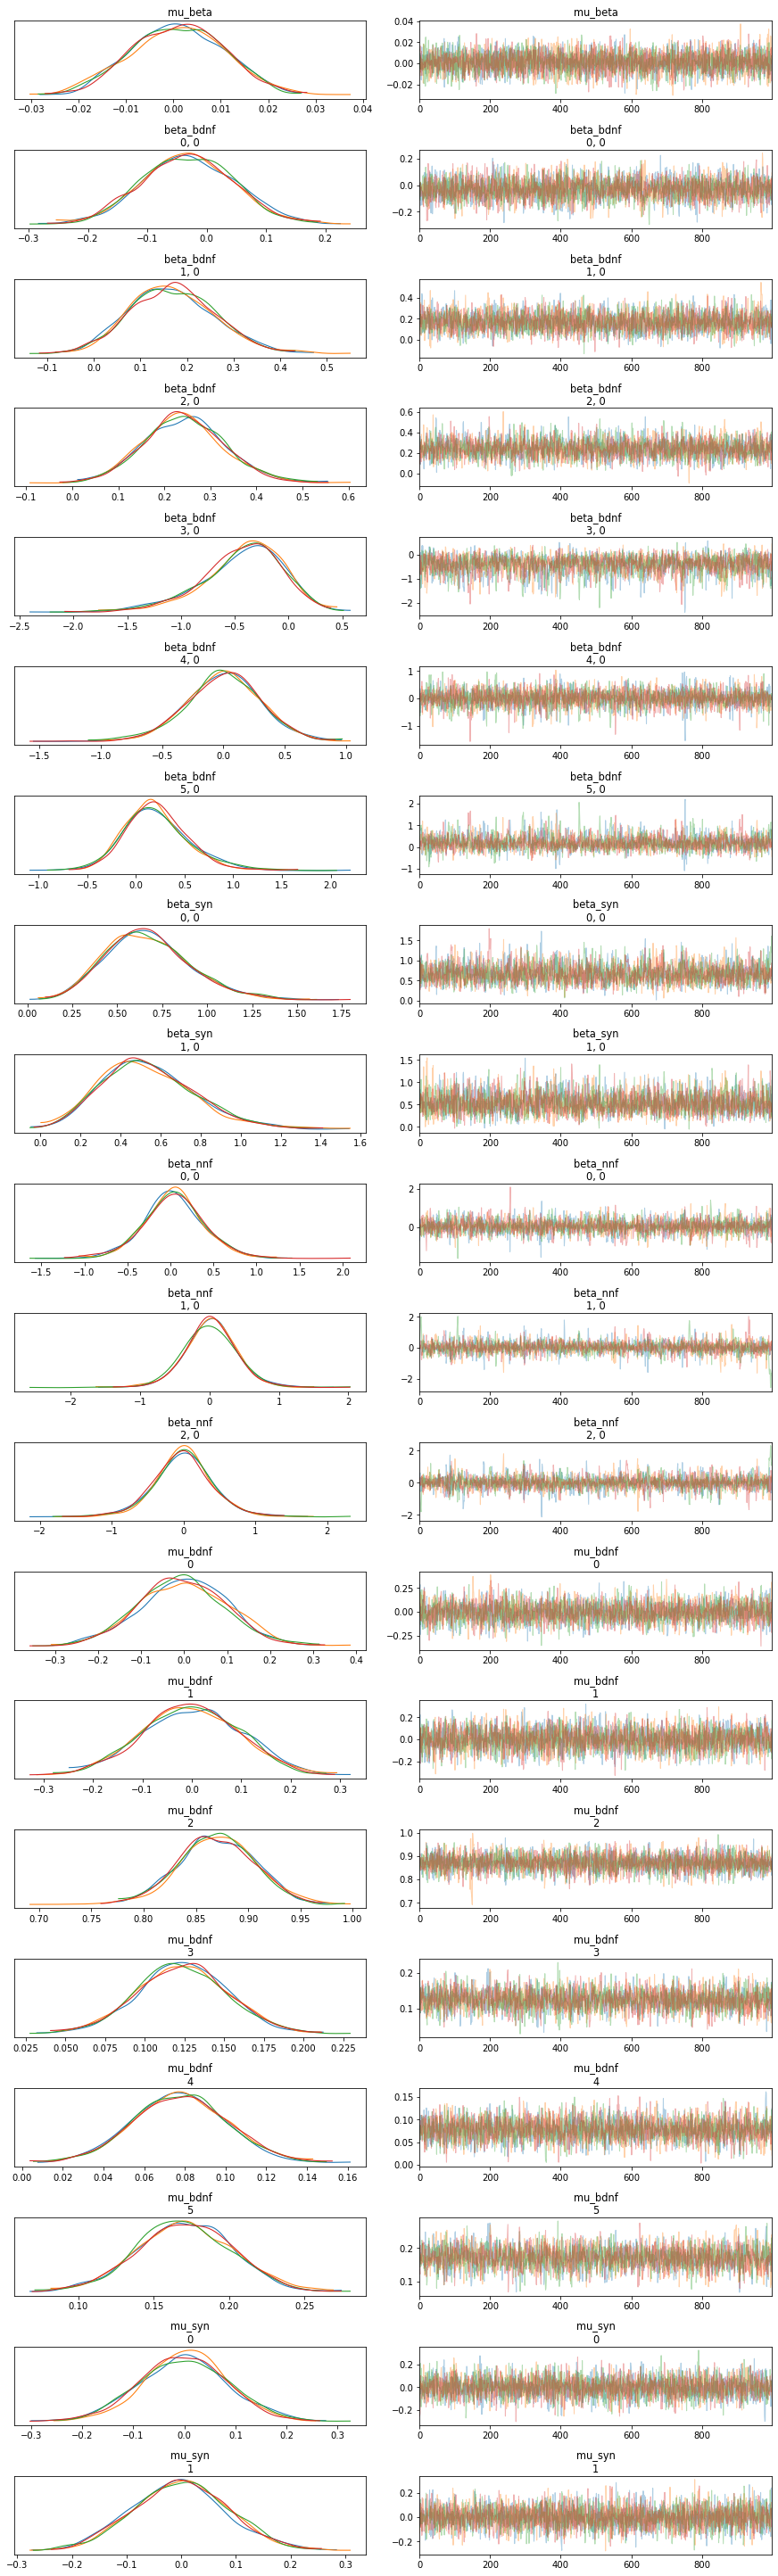

In [20]:
#Check convergence for hyperpriors of two chains
az.plot_trace(trace_cov)

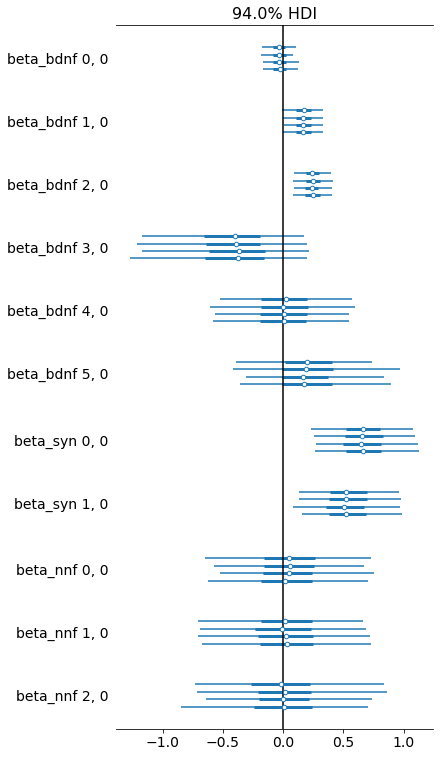

In [22]:
ax = pm.forestplot(trace_cov, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());